# ExpressibilityV0

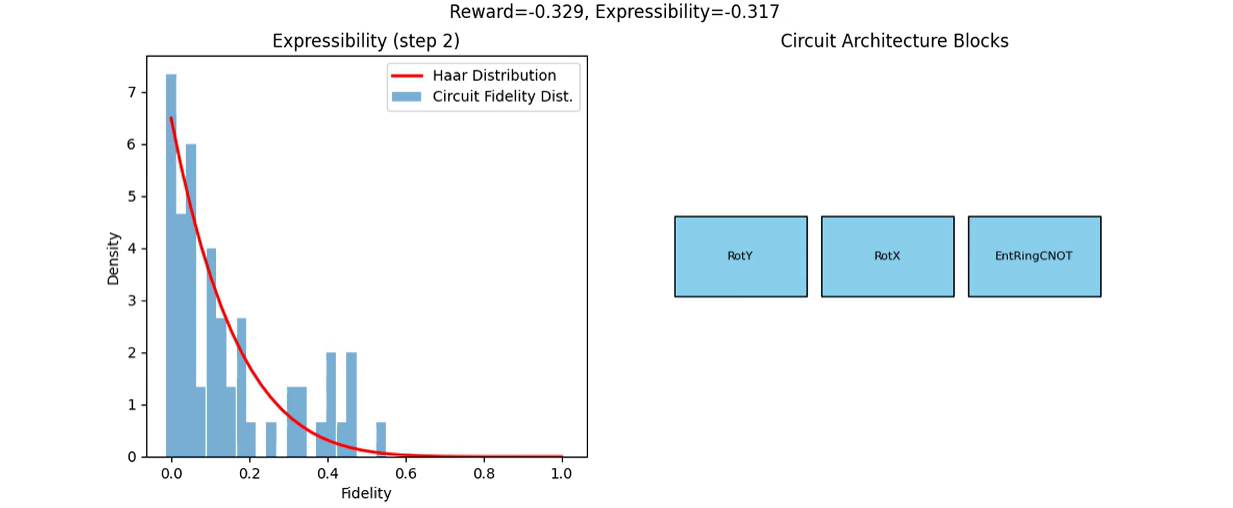

## Description

The **ExpressibilityV0** environment simulates the task of building **parameterized quantum circuits** that achieve **high expressibility**. It is based on the `QuantumEnv` base class. In variational quantum algorithms (VQAs), the expressibility of an ansatz measures how well the circuit can explore the Hilbert space of possible quantum states.

This environment challenges an agent to construct expressive circuits while balancing circuit depth
and gate costs.

At each step, the agent adds or removes blocks (rotation or entangling layers) or decides to terminate construction. The reward is based on how closely the circuit's fidelity distribution matches the Haar-random distribution (an idealized benchmark of maximum expressibility), penalized by circuit depth and two-qubit gate counts.

The environment includes a rendering mode that animates:
1. The evolving **fidelity distribution vs Haar distribution**, and  
2. The **block diagram** of the constructed circuit architecture.  


## Action Space

The action space is a **Discrete(8)** space, where each action corresponds to a modification of
the circuit architecture:

| ID | Action          | Description                                     |
|----|-----------------|-------------------------------------------------|
| 0  | `RotX`          | Add single-qubit RX rotations on all qubits     |
| 1  | `RotY`          | Add single-qubit RY rotations on all qubits     |
| 2  | `RotZ`          | Add single-qubit RZ rotations on all qubits     |
| 3  | `RotXYZ`        | Add RX, RY, RZ rotations on all qubits          |
| 4  | `EntRingCNOT`   | Add a ring of CNOT entanglers                   |
| 5  | `EntLadderCZ`   | Add ladder-style CZ entanglers                  |
| 6  | `RemoveLast`    | Remove the most recently added block            |
| 7  | `Terminate`     | Stop circuit construction and end the episode   |


## Observation Space

The observation is a **7-dimensional vector** summarizing circuit statistics:
[depth, n_blocks, n_twoq, n_params, ent_density, last_express, steps_left]

Where:
- **`depth`**: Total circuit depth  
- **`n_blocks`**: Number of blocks in the circuit  
- **`n_twoq`**: Number of two-qubit gates  
- **`n_params`**: Number of trainable rotation parameters  
- **`ent_density`**: Entangling density relative to possible qubit connections  
- **`last_express`**: Last computed expressibility score  
- **`steps_left`**: Remaining steps before max_steps is reached  


## Rewards

The reward encourages high expressibility while penalizing excessive depth and two-qubit usage:

$reward = - KL(P_C \,\|\, P_{Haar}) \;-\; \lambda_{depth}\cdot depth \;-\; \lambda_{2q}\cdot n_{twoq}$

Where:
- **KL**: Kullback-Leibler divergence between circuit fidelity distribution `P_C`
and Haar-random distribution `P_Haar`.  
- **λ_depth, λ_2q**: Regularization weights for penalizing large depth and two-qubit gates.  
- **Terminate bonus**: A small positive reward (`terminate_bonus`) is added if the agent terminates explicitly.  

Interpretation:
- High reward = Circuit closely mimics Haar distribution, shallow, and efficient.  
- Low reward = Circuit deviates significantly from Haar distribution or becomes overly complex.  


## Starting State

At the beginning of each episode:
- The circuit is empty (`blocks = []`).
- The observation corresponds to a circuit with zero depth, parameters, and entangling density.
- The first reward is undefined until the agent applies at least one block.


## Episode End

The episode ends under either condition:
1. **Termination**: Agent selects `Terminate` action (ID=7).  
2. **Truncation**: Maximum number of steps (`max_steps`, default=20) is reached.  

## Rendering

The rendering shows a **two-panel animation**:

1. **Left panel**:  
- Histogram of circuit fidelity distribution vs. Haar-random distribution.  
- The closer the two curves overlap, the more expressive the circuit is.  

2. **Right panel**:  
- Block diagram of the constructed circuit architecture, showing the sequence of blocks.  

The figure title includes **reward and expressibility score** for the current step.  
The animation can be displayed interactively or saved as an MP4 file.

## Arguments

- **`n_qubits`** (`int`, default=4): Number of qubits.  
- **`max_blocks`** (`int`, default=12): Maximum number of blocks allowed in the circuit.  
- **`max_steps`** (`int`, default=20): Maximum steps per episode.  
- **`n_pairs_eval`** (`int`, default=120): Number of random state pairs used to evaluate expressibility.  
- **`bins`** (`int`, default=50): Number of histogram bins for fidelity distribution.  
- **`lambda_depth`** (`float`, default=0.002): Penalty weight for depth.  
- **`lambda_2q`** (`float`, default=0.002): Penalty weight for two-qubit gates.  
- **`terminate_bonus`** (`float`, default=0.1): Bonus reward for explicit termination.  
- **`device_name`** (`str`, default="default.qubit"): PennyLane device backend.  
- **`seed`** (`int`, optional): Random seed for reproducibility.  
- **`allow_all_to_all`** (`bool`, default=False): Allow inclusion of all-to-all entangling ISWAP blocks.
- **`ffmpeg`** (`bool`, default=False): If `True`, uses FFmpeg for saving animations; otherwise uses Pillow (GIF).


Episode return: -6.780126503732342


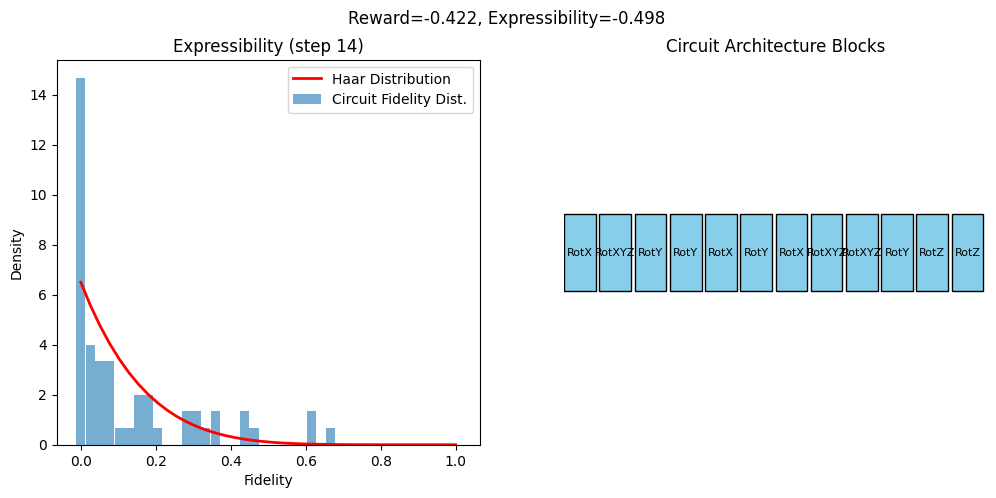

In [ ]:
from qrl.env import ExpressibilityV0

# set ffmpeg=True if you have ffmpeg installed to save as mp4, or ffmpeg=False to save as gif
env = ExpressibilityV0(n_qubits=3, n_pairs_eval=60, bins=40, seed=7,ffmpeg=False)
obs, _ = env.reset()
done = False
total = 0
while not done:
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    total += reward
env.render(r'expressibilityV0')
print("Episode return:", total)